## 2D-epsilon 

In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

## AD/CN data

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


## Sagital/Coronal/Axial slices

In [3]:
def sagital_adjacent_slices(img_n_mmni, m, epsilon, y_tuple, z_tuple):
    crop_img = img_n_mmni.slicer[m-epsilon:m+epsilon+1:epsilon, y_tuple[0]:y_tuple[1], z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (1, 2, 0))
    return crop_img

def coronal_adjacent_slices(img_n_mmni, x_tuple, m, epsilon, z_tuple):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], m-epsilon:m+epsilon+1:epsilon, z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (0, 2, 1))
    return crop_img

def axial_adjacent_slices(img_n_mmni, x_tuple, y_tuple, m, epsilon):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], y_tuple[0]:y_tuple[1], m-epsilon:m+epsilon+1:epsilon]
    return crop_img.get_fdata()


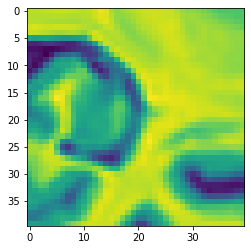

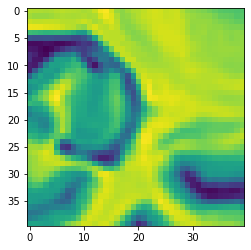

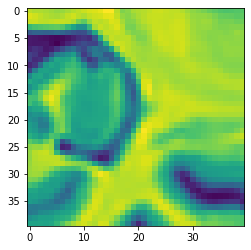

In [4]:
# get an image n_mmni
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)

#Test of coronal projection
img_data = coronal_adjacent_slices(img_n_mmni, (40,80), 110, 1,(40,80))

img_data = coronal_adjacent_slices(img_n_mmni, (100,140), 110, 1,(40,80))


for i in range(3):
    plt.imshow(img_data[:, :, i])
    plt.show()

In [5]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head(7)


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [6]:
print(y_data.shape)

(420, 2)


## Dataset preparation (NO Data augmentation)

In [7]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
            i=0
            img_3_projections = []
            img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
            img_3_projections.append(img_slices_data)

            img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
            img_3_projections.append(img_slices_data)

            img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
            img_3_projections.append(img_slices_data)

            img_3_projections = np.array(img_3_projections)
            X_data.append(img_3_projections)

            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)

    X_data = np.array(X_data)   
    return X_data, Y_data


2022-12-19 13:53:21.614344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 13:53:24.505313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 13:53:24.505367: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 13:53:32.946844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [8]:
X_data, Y_data = Data_preparation(y_data, 1) #epsilon=1
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(419, 3, 40, 40, 3)
419


## Split Dataset 80% train (AD/CN) , 20%Test (AD/CN)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=49) 

print("len(X_train) = ", len(X_train))
print("len(X_test) = ", len(X_test))

len(X_train) =  335
len(X_test) =  84


## Network

In [10]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32

    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

    
model = create_model_2D_epsilon(X_train[0].shape)
model.summary()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

    

2022-12-19 13:56:24.960854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-19 13:56:24.976579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymougou-VivoBook-15-ASUS-Laptop-X540UB): /proc/driver/nvidia/version does not exist
2022-12-19 13:56:25.038582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 40, 40, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 40, 40, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [11]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=40, validation_data=(X_test, Y_test), callbacks=[callback])

2022-12-19 13:56:27.766151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19296000 exceeds 10% of free system memory.


Epoch 1/40
11/11 [==============================] - 9s 292ms/step - loss: 0.8016 - accuracy: 0.5254 - val_loss: 1.2090 - val_accuracy: 0.3929
Epoch 2/40
11/11 [==============================] - 2s 184ms/step - loss: 0.6421 - accuracy: 0.6507 - val_loss: 0.9597 - val_accuracy: 0.3929
Epoch 3/40
11/11 [==============================] - 2s 182ms/step - loss: 0.5433 - accuracy: 0.7672 - val_loss: 0.9130 - val_accuracy: 0.3929
Epoch 4/40
11/11 [==============================] - 2s 178ms/step - loss: 0.4776 - accuracy: 0.8149 - val_loss: 0.8634 - val_accuracy: 0.3929
Epoch 5/40
11/11 [==============================] - 2s 180ms/step - loss: 0.4323 - accuracy: 0.8567 - val_loss: 0.8115 - val_accuracy: 0.3929
Epoch 6/40
11/11 [==============================] - 2s 188ms/step - loss: 0.4049 - accuracy: 0.8597 - val_loss: 0.7564 - val_accuracy: 0.4167
Epoch 7/40
11/11 [==============================] - 2s 189ms/step - loss: 0.3816 - accuracy: 0.8597 - val_loss: 0.7180 - val_accuracy: 0.5238
Epoch 

In [12]:
def plot_loss_curves(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    nb_epochs = range(len(history.history['loss']))

    plt.plot(nb_epochs, loss, label='train_loss')
    plt.plot(nb_epochs, val_loss, label='val_loss')
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(nb_epochs, acc, label='train_accuracy')
    plt.plot(nb_epochs, val_acc, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

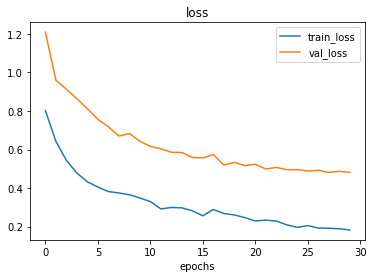

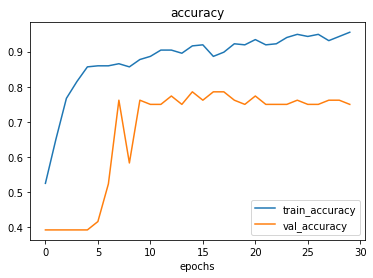

In [13]:
# plot accuarcy and loss 
plot_loss_curves(history)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

labels = np.argmax(Y_test, axis=1)

3/3 [==============================] - 0s 33ms/step


matrix_confusion of AD/CN :
[[43  8]
 [10 23]]


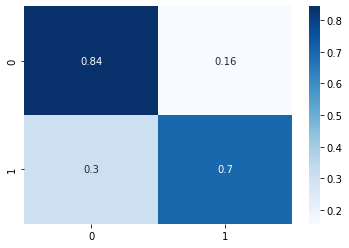

In [15]:
cf_matrix = confusion_matrix(labels, pred)
print("matrix_confusion of AD/CN :")
print(cf_matrix)
cf_matrix = [cf_matrix[0,:]/np.sum(cf_matrix[0,:]), cf_matrix[1,:]/np.sum(cf_matrix[1,:])]
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='.2', cmap='Blues')
plt.show()


## Training with 80% of AD/CN data for MCI 


In [16]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data

In [17]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data_MCI = get_data_MCI(path)
y_data_MCI.head()
print(y_data_MCI.shape)

(300, 3)


In [18]:
from tensorflow.keras.utils import to_categorical

def Data_preparation_MCI(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
            i=0
            img_3_projections = []
            img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
            img_3_projections.append(img_slices_data)

            img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
            img_3_projections.append(img_slices_data)

            img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
            img_3_projections.append(img_slices_data)

            img_3_projections = np.array(img_3_projections)
            X_data.append(img_3_projections)

            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)    


    X_data = np.array(X_data)   
    return X_data, Y_data


In [19]:
X_data_MCI, Y_data_MCI = Data_preparation_MCI(y_data_MCI, 1) #epsilon=1
Y_data_MCI = to_categorical(Y_data_MCI, num_classes=2)

print(X_data_MCI.shape)
print(len(Y_data_MCI))

(300, 3, 40, 40, 3)
300


In [20]:
y_data_MCI = np.argmax(Y_data_MCI, axis= 1)

In [21]:
ypred_model = model.predict(X_data_MCI)

2022-12-19 13:59:45.465074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 17280000 exceeds 10% of free system memory.


10/10 [==============================] - 1s 51ms/step


In [22]:
ypred_model = np.where(ypred_model > 0.5, 1, 0)

In [23]:
from sklearn.metrics import accuracy_score
ypred_model = np.argmax(ypred_model, axis= 1)
acc_model = accuracy_score(ypred_model, y_data_MCI)
print('accuracy on MCI = {} '.format(acc_model))

accuracy on MCI = 0.5966666666666667 


confusion_matrix on MCI :
[[86 43]
 [78 93]]


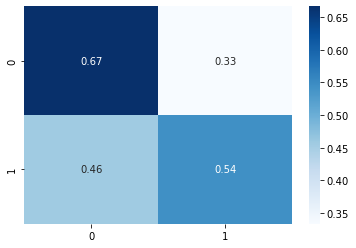

In [26]:
cf_matrix = confusion_matrix(y_data_MCI, ypred_model)
print("confusion_matrix on MCI :")
print(cf_matrix)
cf_matrix = [cf_matrix[0,:]/np.sum(cf_matrix[0,:]), cf_matrix[1,:]/np.sum(cf_matrix[1,:])]
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='.2', cmap='Blues')
plt.show()